In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
cluster.scale(24)
# # # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/envs/mai2021/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39969 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:41326 Dashboard: http://127.0.0.1:39969/status,Cluster Workers: 24 Cores: 168 Memory: 754.89 GiB


In [2]:
import numpy as np
import xarray as xr
import qgutils
import xrft
from xgcm.grid import Grid
import os.path as op
# import dask_image.ndfilters as ndfilters
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/store/tuchida/msom/msqg/'

In [4]:
U = .1
T = 5e5      # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4     # Rossby radius (50km)
Re4 = 4e3
# f0 = 8e-5
beta = .5
Nh = 512
Nl = 128     # Number of horizontal grids
L0 = 80
H = 5e3
dxh = L0/Nh
dxl = L0/Nl  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
# ntime = 187

In [5]:
kNyh = 1/(2*dxh)
kNyl = 1/(2*dxl)

In [6]:
ds_truth = xr.open_dataset(op.join(ddir,'stochas/outdir_0002/vars.nc'))   # high-res "truth"
ds_truth = ds_truth.rename({'t':'time','z':'Z','y':'YC','x':'XC'})
ds_truth.coords['time'] = ('time',ds_truth.time.data)
ds_truth.coords['Z'] = ('Z',np.array([.03,.13,.6]))
ds_truth.coords['YG'] = ('YG',Rd*np.arange(0,L0,dxh))
ds_truth.coords['XG'] = ('XG',Rd*np.arange(0,L0,dxh))
ds_truth.coords['YC'] = ('YC',Rd*np.arange(dxh/2,L0+dxh/2,dxh))
ds_truth.coords['XC'] = ('XC',Rd*np.arange(dxh/2,L0+dxh/2,dxh))
ds_truth.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
ds_truth.coords['drF'] = ('Z',np.array([.06,.14,.8]))
ds_truth.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))
ds_truth = ds_truth.chunk({'time':10,'YC':128,'XC':128})
ds_truth

<xarray.Dataset>
Dimensions:  (XC: 512, XG: 512, YC: 512, YG: 512, Z: 3, Zp1: 4, time: 4977)
Coordinates:
  * YC       (YC) float64 3.906e+03 1.172e+04 1.953e+04 ... 3.988e+06 3.996e+06
  * XC       (XC) float64 3.906e+03 1.172e+04 1.953e+04 ... 3.988e+06 3.996e+06
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 0.0 1.0 2.0 3.0 ... 4.974e+03 4.975e+03 4.976e+03
  * YG       (YG) float64 0.0 7.812e+03 1.562e+04 ... 3.984e+06 3.992e+06
  * XG       (XG) float64 0.0 7.812e+03 1.562e+04 ... 3.984e+06 3.992e+06
  * Zp1      (Zp1) float64 0.0 0.06 0.2 1.0
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    drC      (Zp1) float64 dask.array<chunksize=(4,), meta=np.ndarray>
Data variables:
    p        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    q        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>

In [7]:
ds_coars = xr.open_dataset(op.join(ddir,'no-stoch_N128/outdir_0004/vars.nc'))   # low-res "truth"
ds_coars = ds_coars.rename({'t':'time','z':'Z','y':'YC','x':'XC'})
ds_coars.coords['time'] = ('time',ds_coars.time.data)
ds_coars.coords['Z'] = ('Z',np.array([.03,.13,.6]))
ds_coars.coords['YG'] = ('YG',Rd*np.arange(0,L0,dxl))
ds_coars.coords['XG'] = ('XG',Rd*np.arange(0,L0,dxl))
ds_coars.coords['YC'] = ('YC',Rd*np.arange(dxl/2,L0+dxl/2,dxl))
ds_coars.coords['XC'] = ('XC',Rd*np.arange(dxl/2,L0+dxl/2,dxl))
ds_coars.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
ds_coars.coords['drF'] = ('Z',np.array([.06,.14,.8]))
ds_coars.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))
ds_coars = ds_coars.chunk({'time':10,'YC':128,'XC':128})
ds_coars

<xarray.Dataset>
Dimensions:  (XC: 128, XG: 128, YC: 128, YG: 128, Z: 3, Zp1: 4, time: 4977)
Coordinates:
  * YC       (YC) float64 1.562e+04 4.688e+04 7.812e+04 ... 3.953e+06 3.984e+06
  * XC       (XC) float64 1.562e+04 4.688e+04 7.812e+04 ... 3.953e+06 3.984e+06
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 0.0 1.0 2.0 3.0 ... 4.974e+03 4.975e+03 4.976e+03
  * YG       (YG) float64 0.0 3.125e+04 6.25e+04 ... 3.938e+06 3.969e+06
  * XG       (XG) float64 0.0 3.125e+04 6.25e+04 ... 3.938e+06 3.969e+06
  * Zp1      (Zp1) float64 0.0 0.06 0.2 1.0
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    drC      (Zp1) float64 dask.array<chunksize=(4,), meta=np.ndarray>
Data variables:
    p        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    q        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>

In [8]:
ds01 = xr.open_dataset(op.join(ddir,'stochas/outdir_0047/vars.nc'))
ds01 = ds01.rename({'t':'time','z':'Z','y':'YC','x':'XC'})
ds01.coords['time'] = ('time',ds01.time.data)
ds01.coords['Z'] = ('Z',np.array([.03,.13,.6]))
ds01.coords['YG'] = ('YG',Rd*np.arange(0,L0,dxl))
ds01.coords['XG'] = ('XG',Rd*np.arange(0,L0,dxl))
ds01.coords['YC'] = ('YC',Rd*np.arange(dxl/2,L0+dxl/2,dxl))
ds01.coords['XC'] = ('XC',Rd*np.arange(dxl/2,L0+dxl/2,dxl))
ds01.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
ds01.coords['drF'] = ('Z',np.array([.06,.14,.8]))
ds01.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))
ds01 = ds01.chunk({'time':10,'YC':128,'XC':128})
ds01

<xarray.Dataset>
Dimensions:  (XC: 128, XG: 128, YC: 128, YG: 128, Z: 3, Zp1: 4, time: 4977)
Coordinates:
  * YC       (YC) float64 1.562e+04 4.688e+04 7.812e+04 ... 3.953e+06 3.984e+06
  * XC       (XC) float64 1.562e+04 4.688e+04 7.812e+04 ... 3.953e+06 3.984e+06
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 0.0 1.0 2.0 3.0 ... 4.974e+03 4.975e+03 4.976e+03
  * YG       (YG) float64 0.0 3.125e+04 6.25e+04 ... 3.938e+06 3.969e+06
  * XG       (XG) float64 0.0 3.125e+04 6.25e+04 ... 3.938e+06 3.969e+06
  * Zp1      (Zp1) float64 0.0 0.06 0.2 1.0
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    drC      (Zp1) float64 dask.array<chunksize=(4,), meta=np.ndarray>
Data variables:
    p        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    q        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>

In [9]:
ds05 = xr.open_dataset(op.join(ddir,'stochas/outdir_0048/vars.nc'))
ds05 = ds05.rename({'t':'time','z':'Z','y':'YC','x':'XC'})
ds05.coords['time'] = ('time',ds05.time.data)
ds05.coords['Z'] = ('Z',np.array([.03,.13,.6]))
ds05.coords['YG'] = ('YG',Rd*np.arange(0,L0,dxl))
ds05.coords['XG'] = ('XG',Rd*np.arange(0,L0,dxl))
ds05.coords['YC'] = ('YC',Rd*np.arange(dxl/2,L0+dxl/2,dxl))
ds05.coords['XC'] = ('XC',Rd*np.arange(dxl/2,L0+dxl/2,dxl))
ds05.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
ds05.coords['drF'] = ('Z',np.array([.06,.14,.8]))
ds05.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))
ds05 = ds05.chunk({'time':10,'YC':128,'XC':128})
ds05

<xarray.Dataset>
Dimensions:  (XC: 128, XG: 128, YC: 128, YG: 128, Z: 3, Zp1: 4, time: 4977)
Coordinates:
  * YC       (YC) float64 1.562e+04 4.688e+04 7.812e+04 ... 3.953e+06 3.984e+06
  * XC       (XC) float64 1.562e+04 4.688e+04 7.812e+04 ... 3.953e+06 3.984e+06
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 0.0 1.0 2.0 3.0 ... 4.974e+03 4.975e+03 4.976e+03
  * YG       (YG) float64 0.0 3.125e+04 6.25e+04 ... 3.938e+06 3.969e+06
  * XG       (XG) float64 0.0 3.125e+04 6.25e+04 ... 3.938e+06 3.969e+06
  * Zp1      (Zp1) float64 0.0 0.06 0.2 1.0
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    drC      (Zp1) float64 dask.array<chunksize=(4,), meta=np.ndarray>
Data variables:
    p        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    q        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>

In [10]:
dsb = ds_truth.isel(time=slice(None,None)).mean('time')
dsp = ds_truth.isel(time=slice(None,None)) - dsb
dsp

<xarray.Dataset>
Dimensions:  (XC: 512, XG: 512, YC: 512, YG: 512, Z: 3, Zp1: 4, time: 4977)
Coordinates:
  * YC       (YC) float64 3.906e+03 1.172e+04 1.953e+04 ... 3.988e+06 3.996e+06
  * XC       (XC) float64 3.906e+03 1.172e+04 1.953e+04 ... 3.988e+06 3.996e+06
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 0.0 1.0 2.0 3.0 ... 4.974e+03 4.975e+03 4.976e+03
  * YG       (YG) float64 0.0 7.812e+03 1.562e+04 ... 3.984e+06 3.992e+06
  * XG       (XG) float64 0.0 7.812e+03 1.562e+04 ... 3.984e+06 3.992e+06
  * Zp1      (Zp1) float64 0.0 0.06 0.2 1.0
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    drC      (Zp1) float64 dask.array<chunksize=(4,), meta=np.ndarray>
Data variables:
    p        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    q        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>

In [11]:
dsb_c = ds_coars.isel(time=slice(None,None)).mean('time')
dsp_c = ds_coars.isel(time=slice(None,None)) - dsb_c
dsp_c

<xarray.Dataset>
Dimensions:  (XC: 128, XG: 128, YC: 128, YG: 128, Z: 3, Zp1: 4, time: 4977)
Coordinates:
  * YC       (YC) float64 1.562e+04 4.688e+04 7.812e+04 ... 3.953e+06 3.984e+06
  * XC       (XC) float64 1.562e+04 4.688e+04 7.812e+04 ... 3.953e+06 3.984e+06
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 0.0 1.0 2.0 3.0 ... 4.974e+03 4.975e+03 4.976e+03
  * YG       (YG) float64 0.0 3.125e+04 6.25e+04 ... 3.938e+06 3.969e+06
  * XG       (XG) float64 0.0 3.125e+04 6.25e+04 ... 3.938e+06 3.969e+06
  * Zp1      (Zp1) float64 0.0 0.06 0.2 1.0
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    drC      (Zp1) float64 dask.array<chunksize=(4,), meta=np.ndarray>
Data variables:
    p        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>
    q        (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>

In [12]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions

    
    if nd == 3:
        psi = qgutils.pad_bc(psi, bc=bc)
    else:
        if nd == 2:
            psi = np.pad(psi,((1,1),(1,1)),'constant')
        elif nd == 4:
            psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')
        elif nd == 5:
            psi = np.pad(psi,((0,0),(0,0),(0,0),(1,1),(1,1)),'constant')

        if (bc == 'dirichlet'): 
            psi[...,0,:]  = -psi[...,1,:]
            psi[...,-1,:] = -psi[...,-2,:]
            psi[...,:,0]  = -psi[...,:,1]
            psi[...,:,-1] = -psi[...,:,-2]

            # corners
            psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
            psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
            psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
            psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

        elif (bc == 'neumann'): 
            psi[...,0,:]  = psi[...,1,:]
            psi[...,-1,:] = psi[...,-2,:]
            psi[...,:,0]  = psi[...,:,1]
            psi[...,:,-1] = psi[...,:,-2]

            # corners
            psi[...,0,0]   = psi[...,1,1]
            psi[...,-1,0]  = psi[...,-2,1]
            psi[...,0,-1]  = psi[...,1,-2]
            psi[...,-1,-1] = psi[...,-2,-2]

    return psi


def laplacian(psi, Delta=1, bc='dirichlet', padded=False, 
              dim=['Z','Yp1','Xp1'], chunks={'Yp1':100,'Xp1':100}
             ):
    
    nd = psi.ndim
    if padded:
        psi_padded = psi
    else:
        psi_padded = xr.DataArray(pad_bc(psi), dims=dim,
                                  coords={'Yp1':np.arange(-Delta/2,L0+Delta,Delta),
                                          'Xp1':np.arange(-Delta/2,L0+Delta,Delta)}
                                 ).chunk(chunks)

    lap = (psi_padded.isel(Yp1=slice(2,None),Xp1=slice(1,-1)).data 
           + psi_padded.isel(Yp1=slice(None,-2),Xp1=slice(1,-1)).data
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(2,None)).data 
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(None,-2)).data
           - 4*psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).data
          ) / Delta**2

    return xr.DataArray(lap, dims=psi_padded.dims, 
                        coords=psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).coords
                       )

In [13]:
psi_padded = xr.DataArray(pad_bc(dsp_c.p.values), 
                          dims=['time','Z','Yp1','Xp1'],
                          coords={'time':dsp_c.time.data,
                                  'Z':dsp_c.Z.data,
                                  'Yp1':Rd*np.arange(-dxl/2,L0+dxl,dxl),
                                  'Xp1':Rd*np.arange(-dxl/2,L0+dxl,dxl)}
                         ).chunk({'time':10,'Yp1':-1,'Xp1':-1})

uc = -psi_padded.isel(Xp1=slice(1,-1)).diff('Yp1') / dxl
vc = psi_padded.isel(Yp1=slice(1,-1)).diff('Xp1') / dxl
uc

,Array,Chunk
Bytes,0.92 GiB,1.89 MiB
Shape,"(4977, 3, 129, 128)","(10, 3, 129, 128)"
Count,3486 Tasks,498 Chunks
Type,float32,numpy.ndarray


In [14]:
psi_padded = xr.DataArray(pad_bc(ds01.p.values), 
                          dims=['time','Z','Yp1','Xp1'],
                          coords={'time':ds01.time.data,
                                  'Z':ds01.Z.data,
                                  'Yp1':Rd*np.arange(-dxl/2,L0+dxl,dxl),
                                  'Xp1':Rd*np.arange(-dxl/2,L0+dxl,dxl)}
                         ).chunk({'time':10,'Yp1':-1,'Xp1':-1})

u01 = -psi_padded.isel(Xp1=slice(1,-1)).diff('Yp1') / dxl
v01 = psi_padded.isel(Yp1=slice(1,-1)).diff('Xp1') / dxl
u01

,Array,Chunk
Bytes,0.92 GiB,1.89 MiB
Shape,"(4977, 3, 129, 128)","(10, 3, 129, 128)"
Count,3486 Tasks,498 Chunks
Type,float32,numpy.ndarray


In [15]:
psi_padded = xr.DataArray(pad_bc(ds05.p.values), 
                          dims=['time','Z','Yp1','Xp1'],
                          coords={'time':ds05.time.data,
                                  'Z':ds05.Z.data,
                                  'Yp1':Rd*np.arange(-dxl/2,L0+dxl,dxl),
                                  'Xp1':Rd*np.arange(-dxl/2,L0+dxl,dxl)}
                         ).chunk({'time':10,'Yp1':-1,'Xp1':-1})

u05 = -psi_padded.isel(Xp1=slice(1,-1)).diff('Yp1') / dxl
v05 = psi_padded.isel(Yp1=slice(1,-1)).diff('Xp1') / dxl
u05

,Array,Chunk
Bytes,0.92 GiB,1.89 MiB
Shape,"(4977, 3, 129, 128)","(10, 3, 129, 128)"
Count,3486 Tasks,498 Chunks
Type,float32,numpy.ndarray


In [16]:
psi_padded = xr.DataArray(pad_bc(dsp.p.values), 
                          dims=['time','Z','Yp1','Xp1'],
                          coords={'time':dsp.time.data,
                                  'Z':dsp.Z.data,
                                  'Yp1':Rd*np.arange(-dxh/2,L0+dxh,dxh),
                                  'Xp1':Rd*np.arange(-dxh/2,L0+dxh,dxh)}
                         ).chunk({'time':10,'Yp1':-1,'Xp1':-1})

up = -psi_padded.isel(Xp1=slice(1,-1)).diff('Yp1') / dxh
vp = psi_padded.isel(Yp1=slice(1,-1)).diff('Xp1') / dxh
up

,Array,Chunk
Bytes,14.61 GiB,30.06 MiB
Shape,"(4977, 3, 513, 512)","(10, 3, 513, 512)"
Count,3486 Tasks,498 Chunks
Type,float32,numpy.ndarray


In [17]:
uck = xrft.isotropic_power_spectrum(xr.DataArray(.5*(uc.isel(Yp1=slice(1,None)).data + uc.isel(Yp1=slice(None,-1)).data),
                                                dims=dsp_c.p.dims, coords=dsp_c.p.coords
                                               ).chunk({'YC':-1,'XC':-1}),
                                   dim=['YC','XC'], 
                                   detrend='linear', window="hann", window_correction=True
                                  )
vck = xrft.isotropic_power_spectrum(xr.DataArray(.5*(vc.isel(Xp1=slice(1,None)).data + vc.isel(Xp1=slice(None,-1)).data),
                                                dims=dsp_c.p.dims, coords=dsp_c.p.coords
                                               ).chunk({'YC':-1,'XC':-1}), 
                                   dim=['YC','XC'],  
                                   detrend='linear', window="hann", window_correction=True
                                  )
u01k = xrft.isotropic_power_spectrum(xr.DataArray(.5*(u01.isel(Yp1=slice(1,None)).data + u01.isel(Yp1=slice(None,-1)).data),
                                                dims=ds01.p.dims, coords=ds01.p.coords
                                               ).chunk({'YC':-1,'XC':-1}),
                                   dim=['YC','XC'], 
                                   detrend='linear', window="hann", window_correction=True
                                  )
v01k = xrft.isotropic_power_spectrum(xr.DataArray(.5*(v01.isel(Xp1=slice(1,None)).data + v01.isel(Xp1=slice(None,-1)).data),
                                                dims=ds01.p.dims, coords=ds01.p.coords
                                               ).chunk({'YC':-1,'XC':-1}), 
                                   dim=['YC','XC'],  
                                   detrend='linear', window="hann", window_correction=True
                                  )
u05k = xrft.isotropic_power_spectrum(xr.DataArray(.5*(u05.isel(Yp1=slice(1,None)).data + u05.isel(Yp1=slice(None,-1)).data),
                                                dims=ds05.p.dims, coords=ds05.p.coords
                                               ).chunk({'YC':-1,'XC':-1}),
                                   dim=['YC','XC'], 
                                   detrend='linear', window="hann", window_correction=True
                                  )
v05k = xrft.isotropic_power_spectrum(xr.DataArray(.5*(v05.isel(Xp1=slice(1,None)).data + v05.isel(Xp1=slice(None,-1)).data),
                                                dims=ds05.p.dims, coords=ds05.p.coords
                                               ).chunk({'YC':-1,'XC':-1}), 
                                   dim=['YC','XC'],  
                                   detrend='linear', window="hann", window_correction=True
                                  )
upk = xrft.isotropic_power_spectrum(xr.DataArray(.5*(up.isel(Yp1=slice(1,None)).data + up.isel(Yp1=slice(None,-1)).data),
                                                 dims=dsp.p.dims, coords=dsp.p.coords
                                                ).chunk({'YC':-1,'XC':-1}),
                                    dim=['YC','XC'], 
                                    detrend='linear', window="hann", window_correction=True
                                   )
vpk = xrft.isotropic_power_spectrum(xr.DataArray(.5*(vp.isel(Xp1=slice(1,None)).data + vp.isel(Xp1=slice(None,-1)).data),
                                                 dims=dsp.p.dims, coords=dsp.p.coords
                                                ).chunk({'YC':-1,'XC':-1}),
                                    dim=['YC','XC'], 
                                    detrend='linear', window="hann", window_correction=True
                                   )

NameError: name 'uk' is not defined

In [18]:
EKE01k0 = U**2*.5*(u01k + v01k).isel(Z=0).mean('time').compute()
EKE05k0 = U**2*.5*(u05k + v05k).isel(Z=0).mean('time').compute()

In [19]:
EKEpk0 = U**2*.5*(upk + vpk).isel(Z=0).mean('time').compute()
EKEpk0

<xarray.DataArray (freq_r: 128)>
array([1.84655732e+00, 3.90128629e+01, 2.62769711e+02, 9.07714497e+02,
       1.34532455e+03, 1.10340209e+03, 7.14792450e+02, 4.48174908e+02,
       3.02351315e+02, 2.09260689e+02, 1.41963114e+02, 9.82394248e+01,
       6.88105006e+01, 4.87124461e+01, 3.55863800e+01, 2.62266019e+01,
       1.95656297e+01, 1.48249842e+01, 1.12602564e+01, 8.59834119e+00,
       6.60330467e+00, 5.08754604e+00, 3.95621315e+00, 3.10463680e+00,
       2.44034817e+00, 1.92443735e+00, 1.52175859e+00, 1.21060521e+00,
       9.70279492e-01, 7.79195714e-01, 6.25471058e-01, 5.04275551e-01,
       4.07813238e-01, 3.29762715e-01, 2.68381312e-01, 2.17791411e-01,
       1.76900580e-01, 1.43321667e-01, 1.16055470e-01, 9.43695725e-02,
       7.68574037e-02, 6.25105429e-02, 5.05954905e-02, 4.09923205e-02,
       3.32142123e-02, 2.69365390e-02, 2.18397584e-02, 1.76297604e-02,
       1.42235017e-02, 1.14685810e-02, 9.24531684e-03, 7.44464479e-03,
       5.99175368e-03, 4.79598487e-03, 3.83947475e-03, 3.06969199e-03,
       2.44344482e-03, 1.94976507e-03, 1.55013700e-03, 1.22511174e-03,
       9.68544353e-04, 7.64045988e-04, 6.00466472e-04, 4.71639546e-04,
       3.69181194e-04, 2.86659796e-04, 2.22220243e-04, 1.71512553e-04,
       1.32422504e-04, 1.01284067e-04, 7.72192928e-05, 5.85631413e-05,
       4.40937180e-05, 3.30337114e-05, 2.46519085e-05, 1.82510256e-05,
       1.33769155e-05, 9.74613852e-06, 7.00339686e-06, 5.00771271e-06,
       3.57161147e-06, 2.51219622e-06, 1.73064149e-06, 1.19767595e-06,
       8.13867619e-07, 5.53776335e-07, 3.76897915e-07, 2.54196961e-07,
       1.70798997e-07, 1.18660679e-07, 8.86969332e-08, 7.17704075e-08,
       5.19850679e-08, 3.54567747e-08, 2.35566853e-08, 1.54454540e-08,
       9.84466728e-09, 6.15216235e-09, 3.98346100e-09, 2.50013263e-09,
       1.53065879e-09, 9.87785455e-10, 6.27023696e-10, 4.01659818e-10,
       2.57436787e-10, 1.71245810e-10, 1.17621911e-10, 8.09396862e-11,
       5.86433729e-11, 4.39909145e-11, 3.55176421e-11, 2.74810005e-11,
       2.32097723e-11, 1.97754024e-11, 1.72642862e-11, 1.35209277e-11,
       1.19098516e-11, 1.01638534e-11, 9.85003019e-12, 6.56741452e-12,
       5.34749829e-12, 4.40416828e-12, 3.49431227e-12, 2.45038677e-12,
       1.41697581e-12, 7.10909251e-13, 4.21013243e-13, 1.96030453e-13])
Coordinates:
    Z        float64 0.03
    drF      float64 0.06
  * freq_r   (freq_r) float64 4.686e-07 1.1e-06 ... 8.936e-05 9.001e-05

In [20]:
EKEpk0_c = U**2*.5*(uck + vck).isel(Z=0).mean('time').compute()

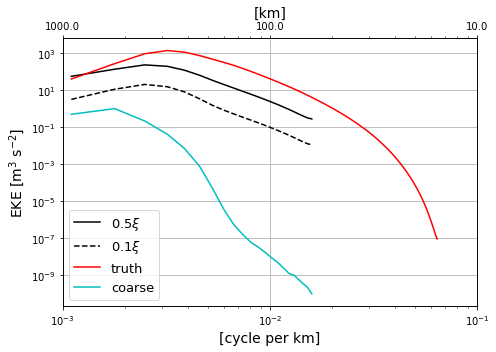

In [21]:
fig, ax = plt.subplots(figsize=(7,5))
fig.set_tight_layout(True)
ax2 = ax.twiny()

ax.plot(EKE05k0.freq_r.isel(freq_r=slice(1,None)).where(EKE05k0.freq_r<=kNyl/Rd)*1e3, 
        EKE05k0.isel(freq_r=slice(1,None)).where(EKE05k0.freq_r<=kNyl/Rd),
        'k', label=r"$0.5\xi$")
ax.plot(EKE01k0.freq_r.isel(freq_r=slice(1,None)).where(EKE01k0.freq_r<=kNyl/Rd)*1e3, 
        EKE01k0.isel(freq_r=slice(1,None)).where(EKE01k0.freq_r<=kNyl/Rd), 
        'k--', label=r"$0.1\xi$")
ax.plot(EKEpk0.freq_r.isel(freq_r=slice(1,None)).where(EKEpk0.freq_r<=kNyh/Rd)*1e3, 
        EKEpk0.isel(freq_r=slice(1,None)).where(EKEpk0.freq_r<=kNyh/Rd), 
        'r', label=r"truth")
ax.plot(EKEpk0_c.freq_r.isel(freq_r=slice(1,None)).where(EKEpk0_c.freq_r<=kNyl/Rd)*1e3, 
        EKEpk0_c.isel(freq_r=slice(1,None)).where(EKEpk0_c.freq_r<=kNyl/Rd), 
        'c', label=r"coarse")
ax2.plot(EKEpk0.freq_r.isel(freq_r=slice(1,None)).where(EKEpk0.freq_r<=kNyl/Rd)*1e3, 
         EKEpk0.isel(freq_r=slice(1,None)).where(EKEpk0.freq_r<=kNyl/Rd), alpha=0)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-3,1e-1])
ax.set_xticks([1e-3,1e-2,1e-1])
ax.set_xlabel("[cycle per km]", fontsize=14)
ax.set_ylabel(r"EKE [m$^3$ s$^{-2}$]", fontsize=14)

ax.legend(loc='lower left', fontsize=13)

ax2.set_xscale('log')
ax2.set_xlim([1e-3,1e-1])
ax2.set_xticks([1e-3,1e-2,1e-1])
ax2.set_xticklabels([1e3,1e2,1e1])
ax2.set_xlabel("[km]", fontsize=14)

ax.grid(True)